<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from sklearn.model_selection import train_test_split



%matplotlib inline

In [19]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [20]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

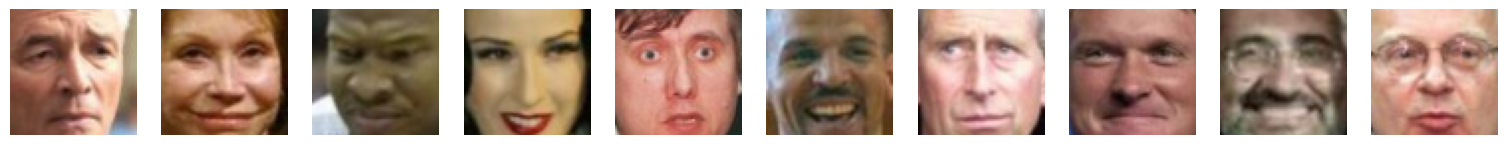

In [21]:
data_train, data_val, train_attrs, val_attrs = train_test_split(data, attrs, train_size=0.9, shuffle=True)
plt.figure(figsize=(20, 5), dpi=96)
for i, gt in enumerate(data_train[:10]):
    plt.subplot(1, 10, i+1)
    plt.imshow(gt)
    plt.axis("off")

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [22]:
dim_features = 64 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [23]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 7),
            nn.Flatten(),
            nn.Linear(64*10*10, dim_features)
        )

        self.decoder = nn.Sequential(
            nn.Linear(dim_features, 64 * 10* 10),
            nn.Unflatten(1, (64, 10, 10)),
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
          )

    def forward(self, x):
        #<реализуйте forward проход автоэнкодера
        #в качестве возвращаемых переменных -- латентное представление картинки (latent_code)
        #и полученная реконструкция изображения (reconstruction)>
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)

        return reconstruction, latent_code

In [24]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

cuda


In [25]:
criterion = nn.MSELoss()

autoencoder = Autoencoder().to(DEVICE)

optimizer = optim.Adam(autoencoder.parameters())

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [26]:
trainloader = torch.utils.data.DataLoader(torch.Tensor(data_train.swapaxes(1,3).swapaxes(2,3)), batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(torch.Tensor(data_val.swapaxes(1,3).swapaxes(2,3)), batch_size=32, shuffle=False)

In [27]:
import copy

def train(model, loss_fn, optimizer, data_tr, data_val, n_epochs = 20):
  losses = []
  for epoch in range(n_epochs):
      model.train()
      current_epoch_loss = 0
      print('')

      for X_batch in data_tr:
        optimizer.zero_grad()
        X_batch = X_batch.float()
        X_batch = X_batch.to(DEVICE)
        reconstruction, latent_space = model(X_batch)
        loss = loss_fn(reconstruction, X_batch)
        loss.backward()
        optimizer.step()
        current_epoch_loss += loss.cpu().item() * X_batch.size(0)

      avg_loss = current_epoch_loss / len(data_tr)

      model.eval()

      running_val_loss = 0.0

      for X_batch_val in data_val:
            X_batch_val = X_batch_val.to(DEVICE)
            reconstruction_val, latent_space_val = model(X_batch_val)
            loss_val = loss_fn(reconstruction_val, X_batch_val)
            running_val_loss += loss_val.cpu().item() * X_batch_val.size(0)

      epoch_val_loss = running_val_loss / len(data_val)

      print('Epoch: {}. Loss: {}'.format(epoch + 1, avg_loss))
      print('Epoch: {}. Val loss: {}'.format(epoch + 1, epoch_val_loss))
      losses.append([avg_loss, epoch_val_loss])

  return losses

In [28]:
torch.cuda.empty_cache()
my_losses = train(autoencoder, criterion, optimizer, data_tr=trainloader, data_val=valloader)


Epoch: 1. Loss: 0.4284644608058639
Epoch: 1. Val loss: 0.19805400165551829

Epoch: 2. Loss: 0.16808367224057785
Epoch: 2. Val loss: 0.1381665970132287

Epoch: 3. Loss: 0.13384783004184028
Epoch: 3. Val loss: 0.1216917843225279

Epoch: 4. Loss: 0.12010115896276123
Epoch: 4. Val loss: 0.11594447093306198

Epoch: 5. Loss: 0.1152211681008339
Epoch: 5. Val loss: 0.11232084313607109

Epoch: 6. Loss: 0.11204103489683287
Epoch: 6. Val loss: 0.11089730942400083

Epoch: 7. Loss: 0.10974152238435439
Epoch: 7. Val loss: 0.10752582639300574

Epoch: 8. Loss: 0.10785822065144375
Epoch: 8. Val loss: 0.10803770109279347

Epoch: 9. Loss: 0.10727586866784337
Epoch: 9. Val loss: 0.10617721823066295

Epoch: 10. Loss: 0.10576400944358996
Epoch: 10. Val loss: 0.10586485053811755

Epoch: 11. Loss: 0.10465027601583987
Epoch: 11. Val loss: 0.10643855470143967

Epoch: 12. Loss: 0.1036588344748157
Epoch: 12. Val loss: 0.10368244784019355

Epoch: 13. Loss: 0.1028517722479395
Epoch: 13. Val loss: 0.106848508463285

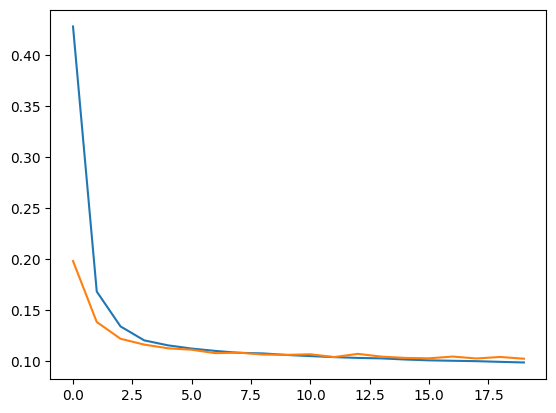

In [29]:
plt.plot(my_losses)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [30]:
# Вывод первых картинок и их реконструкций из валидационной выборки на экран
some_samples = next(iter(valloader))
autoencoder.eval()
with torch.no_grad():
  predictions, latent_space = autoencoder(some_samples.cuda())


In [31]:
some_samples = next(iter(valloader))
autoencoder.eval()
with torch.no_grad():
  predictions, latent_space = autoencoder(some_samples.to(DEVICE))

In [32]:
def to_imshow(x):
  return x.permute(0, 3, 2, 1).permute(0, 2, 1, 3).cpu().detach().numpy()

<ipython-input-36-84db3d98878e>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 10, i+1)


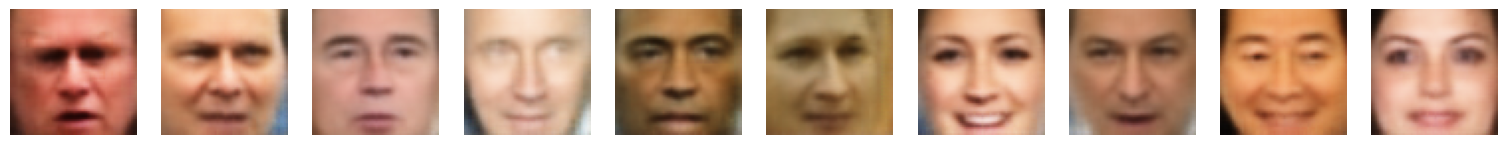

In [36]:
plt.figure(figsize=(20, 7), dpi=96)
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(to_imshow(some_samples)[i])
    plt.axis("off")
    plt.subplot(1, 10, i+1)
    plt.imshow(to_imshow(predictions)[i])
    some_samples = next(iter(valloader))
    plt.axis("off")

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

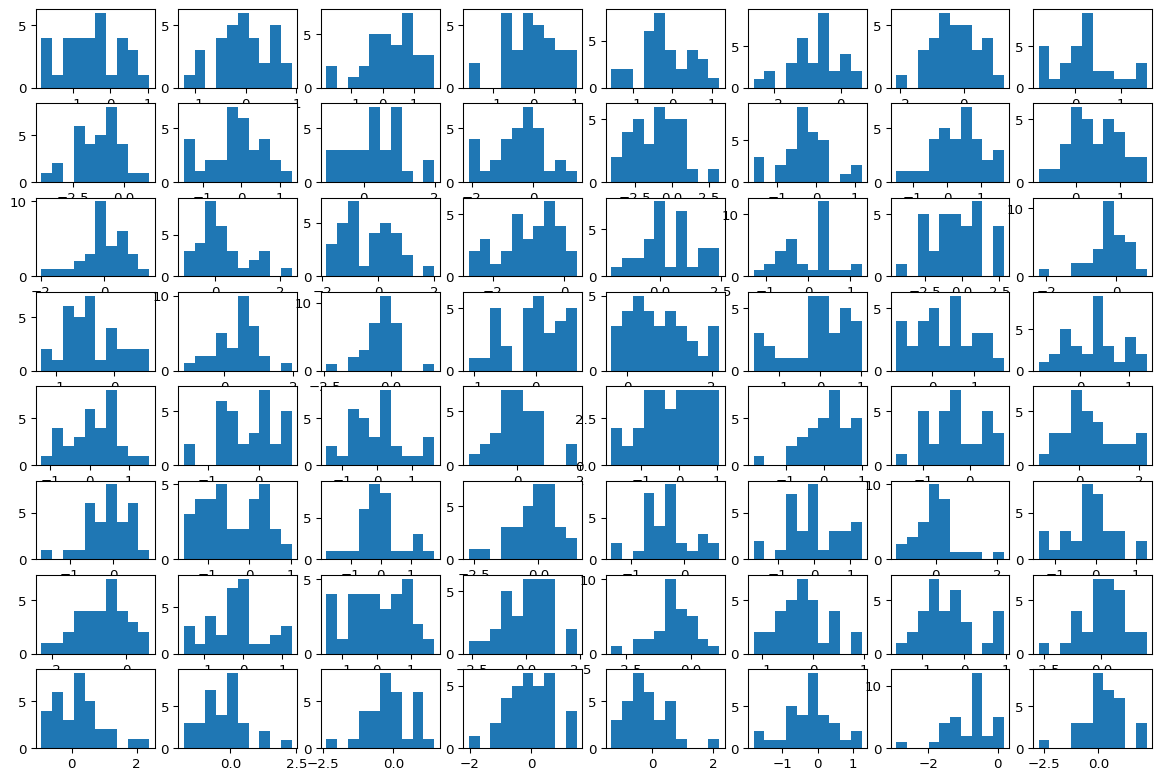

In [37]:
l_space = torch.t(latent_space).cpu()
plt.figure(figsize=(15, 10), dpi=96)
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.hist(l_space[i])
plt.show()


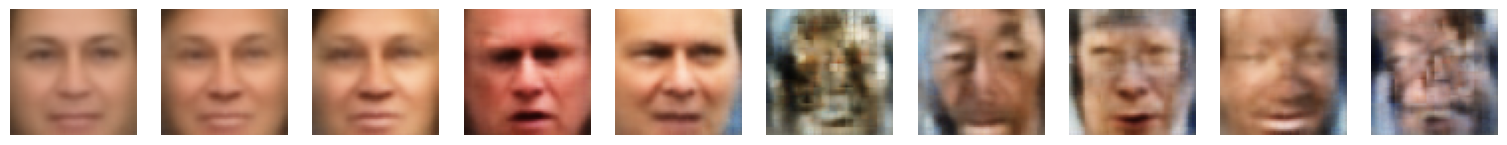

In [39]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(10, dim_features)
z[0] = [sum(e) / len(e) for e in l_space]
z[1] = [(max(e) + min(e)) / 2 for e in l_space]
z[2] = [(max(e) * 0.8 + min(e) * 1.2) / 2 for e in l_space]
z[3] = latent_space.cpu()[0]
z[4] = latent_space.cpu()[1]
autoencoder.eval()
with torch.no_grad():
    output = autoencoder.decoder(torch.Tensor(z).cuda())
plt.figure(figsize=(20, 7), dpi=96)
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(to_imshow(output)[i])
    plt.axis("off")

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

<ipython-input-40-747b52c97dfb>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 10, i + 1)


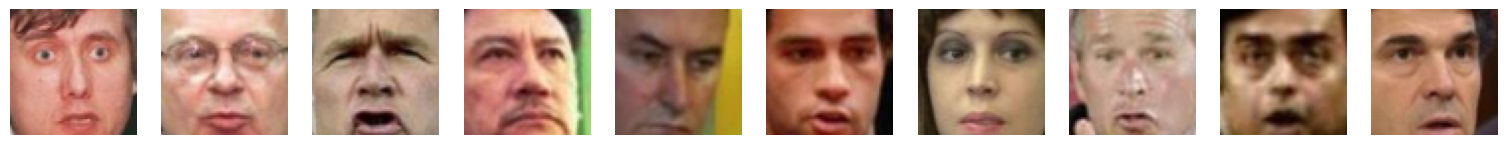

In [40]:

# списки веселых и грустных
smiling_indexes = train_attrs[train_attrs['Smiling'] > 1.5][['Smiling']].index
not_smiling_indexes = train_attrs[train_attrs['Smiling'] < -1.5][['Smiling']].index
plt.figure(figsize=(20, 7), dpi=96)
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(data[smiling_indexes[i]])
    plt.axis("off")
    plt.subplot(1, 10, i + 1)
    plt.imshow(data[not_smiling_indexes[i]])
    plt.axis("off")

In [41]:
print(len(smiling_indexes), len(not_smiling_indexes) )

1149 1277


In [42]:
# Когда мы определили количество грустных (1277) и веселых (1149)
smiling_data = data[smiling_indexes]
unsmiling_data = data[not_smiling_indexes]
smiling_data = torch.Tensor(smiling_data.swapaxes(1,3).swapaxes(2,3))
unsmiling_data = torch.Tensor(unsmiling_data.swapaxes(1,3).swapaxes(2,3))
autoencoder.eval()
with torch.no_grad():
  _, latent_smiling = autoencoder(smiling_data.to(DEVICE))
  _, latent_unsmiling = autoencoder(unsmiling_data.to(DEVICE))

In [43]:
# Вектор улыбки
smile_vector = latent_smiling.mean(dim=0) - latent_unsmiling.mean(dim=0)

In [44]:
def make_smile(autoencoder, data, smile_vector=smile_vector):
  autoencoder.eval()
  with torch.no_grad():
    latent_space = autoencoder.encoder(data.cuda())
    latent_space += smile_vector
    reconstructed = autoencoder.decoder(latent_space).view(-1, 3, 64, 64)
    return reconstructed

In [45]:
generated_data = make_smile(autoencoder, unsmiling_data.to(DEVICE), smile_vector.to(DEVICE))

<ipython-input-47-6c36e2f07fce>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 10, i + 1)


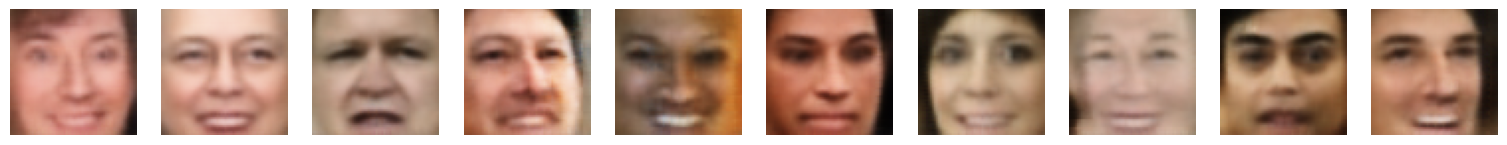

In [47]:
plt.figure(figsize=(20, 7), dpi=96)
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(to_imshow(unsmiling_data)[i])
    plt.axis("off")
    plt.subplot(1, 10, i + 1)
    plt.imshow(to_imshow(generated_data)[i])
    plt.axis("off")

Я не понимаю почему он не выводит грустные лица а только отработанные, где-то я ошибся, но отчетливо не опнимаю где


Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [48]:
from torchvision import transforms

batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 111121327.30it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 119936330.52it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 56218532.22it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 24644927.25it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [57]:
dim_features_vae = 10

In [58]:
class VAE(nn.Module):
    def __init__(self):
        #<определите архитектуры encoder и decoder
        #помните, у encoder должны быть два "хвоста",
        #т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(10),
            nn.LeakyReLU(),

            nn.Conv2d(10, 20, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(20),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Conv2d(20, 40, kernel_size= 3, padding = 1),
            nn.BatchNorm2d(40),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Flatten(),
            nn.Linear(40 * 7 * 7, dim_features_vae * 2)
            )

        self.decoder = nn.Sequential(
            nn.Linear(dim_features_vae, 40 * 7 * 7),
            nn.Unflatten(1, (40, 7, 7)),
            nn.Upsample(scale_factor=2),
            nn.BatchNorm2d(40),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(40, 20, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(20),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(20, 1, kernel_size= 3, stride = 2, padding = 1, output_padding = 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        #<реализуйте forward проход энкодера
        #в качестве ваозвращаемых переменных -- mu и logsigma>
        x = self.encoder(x).view(-1, 2, dim_features_vae)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]

        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            #<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            z = mu + (eps * std)
            return z
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.

            return mu

    def decode(self, z):
        #<реализуйте forward проход декодера
        #в качестве возвращаемой переменной -- reconstruction>
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        #<используя encode и decode, реализуйте forward проход автоэнкодера
        #в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)

        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [59]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = - 0.5 * torch.sum(1 + logsigma - mu.pow(2) - torch.exp(logsigma)) #<напишите код для KL-дивергенции, пользуясь формулой выше>
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction = 'sum') #<binary cross-entropy>
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction) #<соедините тут две компоненты лосса. Mind the sign!>

И обучим модель:

In [60]:
def train(model, loss_fn, optimizer, data_tr, data_val, n_epochs = 20):
  losses = []
  for epoch in range(n_epochs):
      model.train()
      current_epoch_loss = 0
      print('')

      for X_batch, _ in data_tr:
        optimizer.zero_grad()

        X_batch = X_batch.to(DEVICE)
        mu_train, logvar_train, reconstruction = model(X_batch)
        loss = loss_fn(X_batch, mu_train, logvar_train, reconstruction)
        loss.backward()

        optimizer.step()
        current_epoch_loss += loss.cpu().item()

      avg_loss = current_epoch_loss/len(data_tr)
      print('Epoch: {}. Loss: {}'.format(epoch+1,avg_loss))
      losses.append(avg_loss)
  return losses

In [62]:
criterion = loss_vae
vae = VAE().to(DEVICE)
optimizer = optim.Adam(vae.parameters())

In [63]:
# Обучение
torch.cuda.empty_cache()
losses = train(vae, loss_fn=criterion, optimizer=optimizer, data_tr=train_loader, data_val=None, n_epochs=20)


Epoch: 1. Loss: 4676.718169791667

Epoch: 2. Loss: 3663.2977434895834

Epoch: 3. Loss: 3553.9690940104165

Epoch: 4. Loss: 3498.67422265625

Epoch: 5. Loss: 3461.0399868489585

Epoch: 6. Loss: 3432.667924739583

Epoch: 7. Loss: 3413.2862416666667

Epoch: 8. Loss: 3395.6650630208333

Epoch: 9. Loss: 3382.460044661458

Epoch: 10. Loss: 3369.9734505208335

Epoch: 11. Loss: 3361.5178102864584

Epoch: 12. Loss: 3350.4459138020834

Epoch: 13. Loss: 3342.990341927083

Epoch: 14. Loss: 3335.737062109375

Epoch: 15. Loss: 3328.8659838541666

Epoch: 16. Loss: 3324.220238671875

Epoch: 17. Loss: 3319.865908984375

Epoch: 18. Loss: 3314.3135920572918

Epoch: 19. Loss: 3310.978345703125

Epoch: 20. Loss: 3306.687116015625


Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

<ipython-input-64-4d93599a4094>:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 10, i + 1)


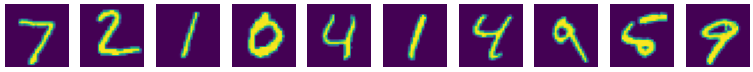

In [64]:
#< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
tempbatch = next(iter(test_loader))[0]

vae.eval()

with torch.no_grad():
  _mu, _logvar, temp_generated = vae(tempbatch.to(DEVICE))

plt.figure(figsize=(20, 7), dpi=48)
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(temp_generated.cpu().detach().squeeze()[i])
    plt.axis("off")
    plt.subplot(2, 10, i + 1)
    plt.imshow(tempbatch.cpu().detach().squeeze()[i])
    plt.axis("off")

На MNIST все проходит без проблем.

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

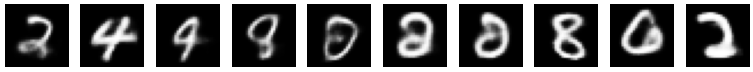

In [65]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
#output = <скормите z декодеру>
#выведите тут полученные картинки>

z = np.array([np.random.normal(0, 1, dim_features_vae) for i in range(10)])
with torch.no_grad():
  temp_generated = vae.decode(torch.Tensor(z).cuda())

# демонстрирую резултат работы
plt.figure(figsize=(20, 7), dpi=48)
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(temp_generated.cpu().detach().squeeze()[i], cmap='gray')
    plt.axis("off")

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [66]:
#<ваш код получения латентных представлений, применения TSNE и визуализации>
vae.eval()
latent_representation = []
i = 0
with torch.no_grad():
  for test_batch, _ in test_loader:
    mu, logvar = vae.encode(test_batch.cuda())
    z = vae.gaussian_sampler(mu, logvar)
    latent_representation.append(z.cpu().detach().numpy())
latent_representation = np.vstack(latent_representation)

In [67]:
from sklearn.manifold import TSNE
tsne = TSNE()
pred = tsne.fit_transform(latent_representation)

<Axes: >

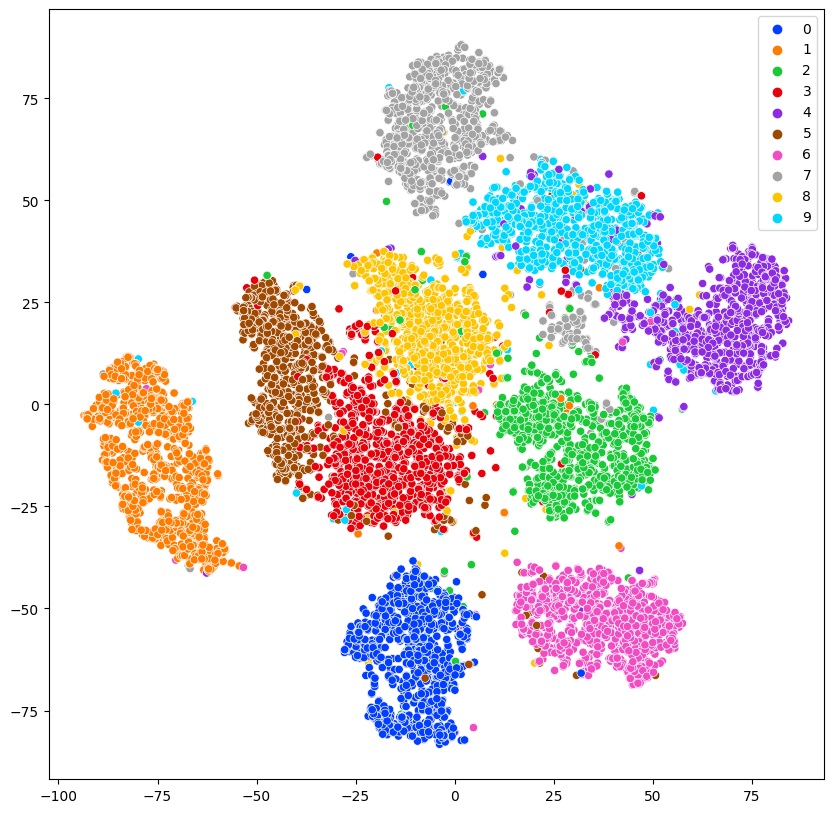

In [68]:
import seaborn as sns

plt.figure(figsize = (10,10))
sns.scatterplot(x=pred[:, 0], y=pred[:, 1], hue = test_dataset.targets, palette=sns.color_palette('bright', 10))

Что вы думаете о виде латентного представления?

Векторы изображений эффективно распределились в двумерном пространстве в соответствии с цифрами. Временами возникают небольшие несоответствия, особенно при схожем написании цифр.

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [69]:
dim_features_cvae = 32

In [70]:
class CVAE(nn.Module):
    def __init__(self):
        #<определите архитектуры encoder и decoder
        #помните, у encoder должны быть два "хвоста",
        #т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28 + 10, 300),
            nn.BatchNorm1d(300),
            nn.ReLU(),

            nn.Linear(300, 150),
            nn.BatchNorm1d(150),
            nn.ReLU(),

            nn.Linear(150, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),

            nn.Linear(50, dim_features_cvae * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(dim_features_cvae + 10, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),

            nn.Linear(50, 150),
            nn.BatchNorm1d(150),
            nn.ReLU(),

            nn.Linear(150, 300),
            nn.BatchNorm1d(300),
            nn.ReLU(),

            nn.Linear(300, 28 * 28),
            nn.Unflatten(1, (1, 28,28)),

            nn.Sigmoid()
        )

    def encode(self, x, class_num):
        #<реализуйте forward проход энкодера
        #в качестве ваозвращаемых переменных -- mu, logsigma и класс картинки>
        a = torch.flatten(x, start_dim = 1)
        b = torch.cat([a, class_num], dim = 1)
        z = self.encoder(b).view(-1, 2, dim_features_cvae)
        mu = z[:, 0, :]
        logsigma = z[:, 1, :]

        return mu, logsigma, class_num

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            #<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + (std * eps)
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, class_num):
        #<реализуйте forward проход декодера
        #в качестве возвращаемой переменной -- reconstruction>
        reconstruction = self.decoder(torch.cat([z, class_num], dim = 1))
        return reconstruction

    def forward(self, x, class_num):
        #<используя encode и decode, реализуйте forward проход автоэнкодера
        #в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logsigma, class_num = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        return mu, logsigma, reconstruction

In [71]:
def train(model, loss_fn, optimizer, data_tr, data_val = None, n_epochs = 20):
  losses = []

  for epoch in range(n_epochs):
    model.train()
    current_epoch_loss = 0
    print('')

    for x_batch, class_num in data_tr:
      optimizer.zero_grad()

      x_batch = x_batch.to(DEVICE)
      class_num = F.one_hot(class_num, 10)
      class_num  = class_num.to(DEVICE)

      mu_train, logsigma_train, reconstruction = model(x_batch, class_num)

      loss = loss_fn(x_batch, mu_train, logsigma_train, reconstruction)

      loss.backward()

      optimizer.step()

      current_epoch_loss += loss.cpu().item()

    avg_loss = current_epoch_loss/ len(data_tr)
    print('Epoch: {}. Loss: {}'.format(epoch+1, avg_loss))
    losses.append(avg_loss)
  return losses

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [72]:
cvae = CVAE().to(DEVICE)
optimizer = optim.Adam(cvae.parameters())
loss = loss_vae

torch.cuda.empty_cache()
losses = train(cvae, loss_fn=loss, optimizer=optimizer, data_tr=train_loader, data_val=None, n_epochs=20)


Epoch: 1. Loss: 4721.6683416666665

Epoch: 2. Loss: 3954.60485234375

Epoch: 3. Loss: 3791.3011458333335

Epoch: 4. Loss: 3713.4634755208335

Epoch: 5. Loss: 3661.3809791666667

Epoch: 6. Loss: 3623.890508203125

Epoch: 7. Loss: 3594.9808032552082

Epoch: 8. Loss: 3568.5419515625

Epoch: 9. Loss: 3550.217604296875

Epoch: 10. Loss: 3529.6638252604166

Epoch: 11. Loss: 3516.4355802083332

Epoch: 12. Loss: 3504.2433565104166

Epoch: 13. Loss: 3493.3785252604166

Epoch: 14. Loss: 3481.644624609375

Epoch: 15. Loss: 3472.816220572917

Epoch: 16. Loss: 3465.9758309895833

Epoch: 17. Loss: 3452.3640197916666

Epoch: 18. Loss: 3445.9878837239585

Epoch: 19. Loss: 3438.85319140625

Epoch: 20. Loss: 3430.5577975260417


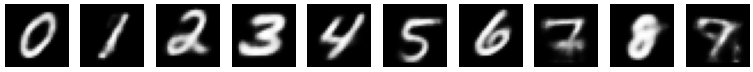

In [73]:
#<тут нужно научиться сэмплировать из декодера цифры определенного класса>
cvae.eval()
indexes_for_onehot = torch.IntTensor([i for i in range(10)]).to(torch.int64)

with torch.no_grad():
  onehot_matrix = F.one_hot(indexes_for_onehot, 10)

  latent_vector = np.array([np.random.normal(0, 1, dim_features_cvae) for i in range(10)])
  temp_generated  = cvae.decode(torch.Tensor(latent_vector).to(DEVICE), onehot_matrix.to(DEVICE)).cpu().detach().squeeze()

plt.figure(figsize=(20, 7), dpi=48)
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(temp_generated[i], cmap='gray')
    plt.axis("off")

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [74]:
#<ваш код получения латентных представлений, применения TSNE и визуализации>
cvae.eval()
latent_representation = []
i = 0
with torch.no_grad():
  for test_batch, class_num in test_loader:
    class_num = F.one_hot(class_num, 10)

    mu, logvar, class_num_1 = cvae.encode(test_batch.cuda(), class_num.cuda())
    z = cvae.gaussian_sampler(mu, logvar)
    latent_representation.append(z.cpu().detach().numpy())
latent_representation = np.vstack(latent_representation)

In [75]:
tsne = TSNE()
pred = tsne.fit_transform(latent_representation)

<Axes: >

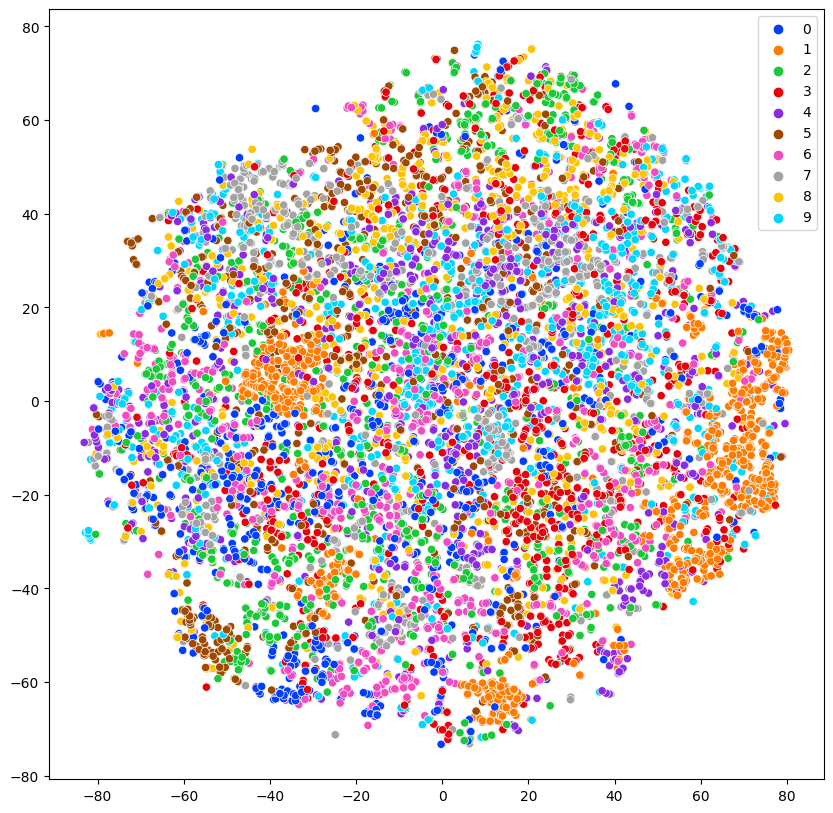

In [76]:
plt.figure(figsize = (10,10))
sns.scatterplot(x=pred[:, 0], y=pred[:, 1], hue = test_dataset.targets, palette=sns.color_palette('bright', 10))

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?ё

**Классы картинок симметричны относительно 0 и перемешанны**

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()